# Topic 2: Recommendation System
### Demo: Underthesea, Gemsim, Cosin Similarity

In [1]:
#!pip install pandas==2.2.2
#!pip install numpy==1.18.5
#pip install gensim
#pip install underthesea

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from underthesea import word_tokenize, pos_tag, sent_tokenize
import warnings
from gensim import corpora, models, similarities
import re

In [3]:
#from google.colab import drive
#drive.mount("/content/gdrive", force_remount=True)

In [4]:
# STOP_WORD_FILE = '/content/gdrive/MyDrive/LDS0/Topic_8_2/demo/vietnamese-stopwords.txt'

In [5]:
STOP_WORD_FILE = 'vietnamese-stopwords.txt'

In [6]:
with open(STOP_WORD_FILE, 'r', encoding='utf-8') as file:
    stop_words = file.read()

stop_words = stop_words.split('\n')

# Underthesea
#### word_tokenize, pos_tag, sent_tokenize
- link: https://github.com/undertheseanlp/underthesea

In [7]:
# đọc tập tin sample_products.csv vào df
df = pd.read_csv("Products_ThoiTrangNam_raw.csv")
df.head()

,product_id,product_name,category,sub_category,link,image,price,rating,description
0,190,"Áo ba lỗ thun gân ,form body tôn dáng",Thời Trang Nam,Áo Ba Lỗ,https://shopee.vn/%C3%81o-ba-l%E1%BB%97-thun-g...,https://cf.shopee.vn/file/2c1ca03f5dc42f316fdf...,86250.0,4.9,Danh Mục\nShopee\nThời Trang Nam\nÁo Ba Lỗ\nCh...
1,191,"Áo Ba Lỗ Nam Trắng Chất Cotton Siêu Mát, Siêu Đẹp",Thời Trang Nam,Áo Ba Lỗ,https://shopee.vn/%C3%81o-Ba-L%E1%BB%97-Nam-Tr...,https://cf.shopee.vn/file/c7ea4c6574dc79be6b26...,26800.0,4.9,Danh Mục\nShopee\nThời Trang Nam\nÁo Ba Lỗ\nXu...
2,192,"Áo Ba Lỗ Nam Tyasuo chất vải co dãn mát, không...",Thời Trang Nam,Áo Ba Lỗ,https://shopee.vn/%C3%81o-Ba-L%E1%BB%97-Nam-Ty...,https://cf.shopee.vn/file/6f93bcda10efe374f8cc...,39500.0,4.8,Danh Mục\nShopee\nThời Trang Nam\nÁo Ba Lỗ\nTh...
3,193,ÁO BA LỖ HÀNG VIỆT NAM 100% COTTON,Thời Trang Nam,Áo Ba Lỗ,https://shopee.vn/%C3%81O-BA-L%E1%BB%96-H%C3%8...,https://cf.shopee.vn/file/1d7ed5e34bff8bc8b49a...,16500.0,4.8,Danh Mục\nShopee\nThời Trang Nam\nÁo Ba Lỗ\nCh...
4,194,Áo Thun Nam Thể Thao Ba Lỗ Mẫu Mới Siêu Đẹp (B...,Thời Trang Nam,Áo Ba Lỗ,https://shopee.vn/%C3%81o-Thun-Nam-Th%E1%BB%83...,NaN,45000.0,4.8,Danh Mục\nShopee\nThời Trang Nam\nÁo Ba Lỗ\nCh...


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49663 entries, 0 to 49662
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   product_id    49663 non-null  int64  
 1   product_name  49663 non-null  object 
 2   category      49663 non-null  object 
 3   sub_category  49663 non-null  object 
 4   link          49663 non-null  object 
 5   image         36443 non-null  object 
 6   price         49663 non-null  float64
 7   rating        49663 non-null  float64
 8   description   48700 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 3.4+ MB


In [9]:
df = df.dropna(subset='description')

In [10]:
import re

# Hàm kiểm tra từ có phải là từ tiếng Việt "sạch"
def is_valid_vietnamese(word):
    vietnamese_chars = (
        "a-zA-Z0-9_"
        "àáạảãâầấậẩẫăằắặẳẵ"
        "èéẹẻẽêềếệểễ"
        "ìíịỉĩ"
        "òóọỏõôồốộổỗơờớợởỡ"
        "ùúụủũưừứựửữ"
        "ỳýỵỷỹ"
        "đ"
        "ÀÁẠẢÃÂẦẤẬẨẪĂẰẮẶẲẴ"
        "ÈÉẸẺẼÊỀẾỆỂỄ"
        "ÌÍỊỈĨ"
        "ÒÓỌỎÕÔỒỐỘỔỖƠỜỚỢỞỠ"
        "ÙÚỤỦŨƯỪỨỰỬỮ"
        "ỲÝỴỶỸ"
        "Đ"
    )
    pattern = f'^[{vietnamese_chars}]+$'
    return re.match(pattern, word) is not None

In [11]:
# Hàm xử lý một mô tả
def filter_vietnamese_words(text):
    if not isinstance(text, str):
        return ''
    words = text.split()
    clean_words = [w for w in words if is_valid_vietnamese(w)]
    return ' '.join(clean_words)

In [12]:
# Áp dụng lọc
df['description_clean'] = df['description'].apply(filter_vietnamese_words)


print(df[['description', 'description_clean']])

                                             description  \
0      Danh Mục\nShopee\nThời Trang Nam\nÁo Ba Lỗ\nCh...   
1      Danh Mục\nShopee\nThời Trang Nam\nÁo Ba Lỗ\nXu...   
2      Danh Mục\nShopee\nThời Trang Nam\nÁo Ba Lỗ\nTh...   
3      Danh Mục\nShopee\nThời Trang Nam\nÁo Ba Lỗ\nCh...   
4      Danh Mục\nShopee\nThời Trang Nam\nÁo Ba Lỗ\nCh...   
...                                                  ...   
49658  Danh Mục\nShopee\nThời Trang Nam\nVớ/Tất\nChiề...   
49659  Danh Mục\nShopee\nThời Trang Nam\nVớ/Tất\nThươ...   
49660  Danh Mục\nShopee\nThời Trang Nam\nVớ/Tất\nChất...   
49661  Danh Mục\nShopee\nThời Trang Nam\nVớ/Tất\nKho ...   
49662  Danh Mục\nShopee\nThời Trang Nam\nVớ/Tất\nXuất...   

                                       description_clean  
0      Danh Mục Shopee Thời Trang Nam Áo Ba Lỗ Chiều ...  
1      Danh Mục Shopee Thời Trang Nam Áo Ba Lỗ Xuất x...  
2      Danh Mục Shopee Thời Trang Nam Áo Ba Lỗ Thương...  
3      Danh Mục Shopee Thời Trang Nam Áo Ba

In [13]:
# Tạo nội dung tổng hợp
# Lựa chọn các thông tin cần thiết để đưa vào phần content (giúp đề xuất nội dung)
# Có thể 1 cột hoặc nhiều cột thông tin
df['Content'] = df['product_name'] + ' ' + df['description_clean'].apply(lambda x: ' '.join(x.split()[:100]))

In [14]:
df.head()

,product_id,product_name,category,sub_category,link,image,price,rating,description,description_clean,Content
0,190,"Áo ba lỗ thun gân ,form body tôn dáng",Thời Trang Nam,Áo Ba Lỗ,https://shopee.vn/%C3%81o-ba-l%E1%BB%97-thun-g...,https://cf.shopee.vn/file/2c1ca03f5dc42f316fdf...,86250.0,4.9,Danh Mục\nShopee\nThời Trang Nam\nÁo Ba Lỗ\nCh...,Danh Mục Shopee Thời Trang Nam Áo Ba Lỗ Chiều ...,"Áo ba lỗ thun gân ,form body tôn dáng Danh Mục..."
1,191,"Áo Ba Lỗ Nam Trắng Chất Cotton Siêu Mát, Siêu Đẹp",Thời Trang Nam,Áo Ba Lỗ,https://shopee.vn/%C3%81o-Ba-L%E1%BB%97-Nam-Tr...,https://cf.shopee.vn/file/c7ea4c6574dc79be6b26...,26800.0,4.9,Danh Mục\nShopee\nThời Trang Nam\nÁo Ba Lỗ\nXu...,Danh Mục Shopee Thời Trang Nam Áo Ba Lỗ Xuất x...,"Áo Ba Lỗ Nam Trắng Chất Cotton Siêu Mát, Siêu ..."
2,192,"Áo Ba Lỗ Nam Tyasuo chất vải co dãn mát, không...",Thời Trang Nam,Áo Ba Lỗ,https://shopee.vn/%C3%81o-Ba-L%E1%BB%97-Nam-Ty...,https://cf.shopee.vn/file/6f93bcda10efe374f8cc...,39500.0,4.8,Danh Mục\nShopee\nThời Trang Nam\nÁo Ba Lỗ\nTh...,Danh Mục Shopee Thời Trang Nam Áo Ba Lỗ Thương...,"Áo Ba Lỗ Nam Tyasuo chất vải co dãn mát, không..."
3,193,ÁO BA LỖ HÀNG VIỆT NAM 100% COTTON,Thời Trang Nam,Áo Ba Lỗ,https://shopee.vn/%C3%81O-BA-L%E1%BB%96-H%C3%8...,https://cf.shopee.vn/file/1d7ed5e34bff8bc8b49a...,16500.0,4.8,Danh Mục\nShopee\nThời Trang Nam\nÁo Ba Lỗ\nCh...,Danh Mục Shopee Thời Trang Nam Áo Ba Lỗ Chất l...,ÁO BA LỖ HÀNG VIỆT NAM 100% COTTON Danh Mục Sh...
4,194,Áo Thun Nam Thể Thao Ba Lỗ Mẫu Mới Siêu Đẹp (B...,Thời Trang Nam,Áo Ba Lỗ,https://shopee.vn/%C3%81o-Thun-Nam-Th%E1%BB%83...,NaN,45000.0,4.8,Danh Mục\nShopee\nThời Trang Nam\nÁo Ba Lỗ\nCh...,Danh Mục Shopee Thời Trang Nam Áo Ba Lỗ Chiều ...,Áo Thun Nam Thể Thao Ba Lỗ Mẫu Mới Siêu Đẹp (B...


In [15]:
# word_tokenize
df["Content_wt"]=df["Content"].apply(lambda x: word_tokenize(x, format="text"))

In [16]:
df[["Content", "Content_wt"]].head()

,Content,Content_wt
0,"Áo ba lỗ thun gân ,form body tôn dáng Danh Mục...","Áo ba lỗ thun gân , form body tôn_dáng Danh_Mụ..."
1,"Áo Ba Lỗ Nam Trắng Chất Cotton Siêu Mát, Siêu ...","Áo Ba_Lỗ Nam_Trắng Chất_Cotton Siêu_Mát , Siêu..."
2,"Áo Ba Lỗ Nam Tyasuo chất vải co dãn mát, không...","Áo Ba_Lỗ Nam_Tyasuo chất vải co_dãn mát , khôn..."
3,ÁO BA LỖ HÀNG VIỆT NAM 100% COTTON Danh Mục Sh...,ÁO BA_LỖ HÀNG_VIỆT_NAM 100 % COTTON Danh_Mục S...
4,Áo Thun Nam Thể Thao Ba Lỗ Mẫu Mới Siêu Đẹp (B...,Áo Thun_Nam Thể_Thao Ba_Lỗ Mẫu_Mới Siêu_Đẹp ( ...


In [17]:
# chuẩn hóa Content_wt chỉ lấy word có nghĩa
df["Content_wt"]=df["Content_wt"].apply(lambda x: ' '.join([word for word in x.split() if not word in stop_words]))

# Cosine_similarity
- link https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html
- link https://en.wikipedia.org/wiki/Cosine_similarity
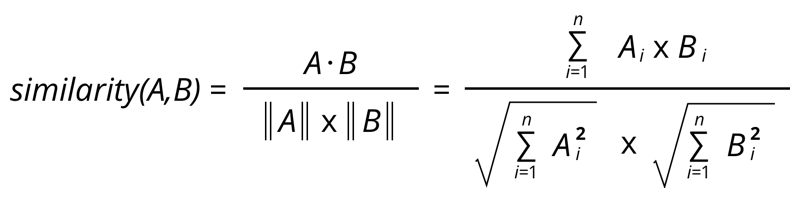

In [18]:
from numpy import dot
from numpy.linalg import norm
A = [1,2]
B = [2,2]
cos_sim = dot(A,B) / (norm(A)*norm(B))
print(cos_sim)

0.9486832980505138


In [19]:
df['Content_wt']

0        Áo ba lỗ thun gân , form body tôn_dáng Danh_Mụ...
1        Áo Ba_Lỗ Nam_Trắng Chất_Cotton Siêu_Mát , Siêu...
2        Áo Ba_Lỗ Nam_Tyasuo chất vải , không xù , mịn ...
3        ÁO BA_LỖ HÀNG_VIỆT_NAM 100 % COTTON Danh_Mục S...
4        Áo Thun_Nam Thể_Thao Ba_Lỗ Mẫu_Mới Siêu_Đẹp ( ...
                               ...                        
49658    Tất_vớ nam cổ cao_cấp , tất_vớ giày công_sở , ...
49659    Tất_Nam Livan_Sport Chất_Liệu Bamboo_Kháng_Khu...
49660    Combo 3 Đôi_Tất ( Vớ ) Hài_Chống Hôi_Chân Uni ...
49661    Hộp 10 đôi tất chống hôi chân_nam Danh_Mục Sho...
49662    Combo 5 đôi tất_nam_nữ cao_cấp không hôi_chân ...
Name: Content_wt, Length: 48700, dtype: object

In [20]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Vector hóa nội dung
vectorizer = TfidfVectorizer(analyzer='word', stop_words=stop_words)
tfidf_matrix = vectorizer.fit_transform(df['Content_wt'])

In [21]:
from sklearn.metrics.pairwise import cosine_similarity

def batched_cosine_similarity(matrix, batch_size=1000):
    n = matrix.shape[0]
    result = []
    for start in range(0, n, batch_size):
        end = min(start + batch_size, n)
        sim_batch = cosine_similarity(matrix[start:end], matrix)
        result.append(sim_batch)
    return result

In [22]:
cosine_sim = batched_cosine_similarity(tfidf_matrix, batch_size=1000)

In [23]:
# Gộp các batch lại thành ma trận 2D
cosine_sim_matrix = np.vstack(cosine_sim)

# Tạo DataFrame
df_show = pd.DataFrame(cosine_sim_matrix)

# Xem kết quả
df_show.head()

,0,1,2,3,4,5,6,7,8,9,...,48690,48691,48692,48693,48694,48695,48696,48697,48698,48699
0,1.000000,0.074751,0.128363,0.099168,0.167026,0.075357,0.135691,0.202086,0.055623,0.069899,...,0.007303,0.014106,0.024540,0.007192,0.003871,0.012824,0.018702,0.007470,0.009845,0.017555
1,0.074751,1.000000,0.194111,0.167028,0.149987,0.227891,0.071826,0.105311,0.135299,0.142727,...,0.053938,0.095120,0.101018,0.003904,0.021948,0.018643,0.022922,0.049057,0.089424,0.052383
2,0.128363,0.194111,1.000000,0.133497,0.125273,0.138858,0.125150,0.089825,0.054536,0.109285,...,0.051549,0.092895,0.110358,0.003850,0.060555,0.027544,0.018072,0.010781,0.027895,0.023343
3,0.099168,0.167028,0.133497,1.000000,0.147348,0.079162,0.093498,0.145545,0.128600,0.141995,...,0.014182,0.016421,0.018288,0.017724,0.021115,0.041895,0.014016,0.012056,0.044615,0.035850
4,0.167026,0.149987,0.125273,0.147348,1.000000,0.097493,0.121357,0.265976,0.067144,0.147222,...,0.022485,0.011146,0.016405,0.010896,0.014267,0.039471,0.014813,0.030127,0.029879,0.045536


In [24]:
# Hàm đề xuất sản phẩm
# # với mỗi sản phẩm, lấy nums sản phẩm tương quan nhất
def get_recommendations(id, cosine_sim=cosine_sim, nums=5):
    idx = df.index[df['product_id'] == id][0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:nums+1]  # Lấy nums sp tương tự nhất
    product_indices = [i[0] for i in sim_scores]
    return df['product_name'].iloc[product_indices]

In [25]:
# Gọi function
recommendations = get_recommendations(190,cosine_sim_matrix,5)
print(recommendations)

28626    [Liên hệ trước khi đặt] Quần Short Kaki unisex...
6400     Áo sơ mi nam dài tay Hàn Quốc vải lụa thái chố...
1043     Áo ba lỗ nam thun cotton - Áo sát nách nam tan...
29966         SET BỘ ĐI CHÙA CỔ THIỀN CÓ THÊU (Có Bigsize)
253      Áo ba lỗ nam thun cotton - Áo sát nách nam tan...
Name: product_name, dtype: object


In [27]:
import numpy as np
import os

os.makedirs("cosine_batches", exist_ok=True)

batch_size = 1000
n = cosine_sim_matrix.shape[0]

for i in range(0, n, batch_size):
    batch = cosine_sim_matrix[i:i + batch_size]
    np.save(f"cosine_batches/cosine_batch_{i // batch_size}.npy", batch)

In [28]:
def load_cosine_batch(index, batch_size=1000):
    batch_file = f"cosine_batches/cosine_batch_{index // batch_size}.npy"
    batch = np.load(batch_file)
    row_index = index % batch_size
    return batch[row_index]

In [30]:
similarities = load_cosine_batch(190)  # 1D array
top10_idx = similarities.argsort()[-11:-1][::-1]
print(top10_idx)

[ 741  983  644 1204 1197 1078  641 1219  638  632]


In [31]:
def get_recommendations(df, ma_san_pham, cosine_sim=cosine_sim, nums=5):
    # Get the index of the hotel that matches the hotel_id
    matching_indices = df.index[df['ma_san_pham'] == ma_san_pham].tolist()
    if not matching_indices:
        print(f"No hotel found with ID: {ma_san_pham}")
        return pd.DataFrame()  # Return an empty DataFrame if no match
    idx = matching_indices[0]

    # Get the pairwise similarity scores of all hotels with that hotel
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the hotels based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar hotels (Ignoring the hotel itself)
    sim_scores = sim_scores[1:nums+1]

    # Get the hotel indices
    product_indices = [i[0] for i in sim_scores]

    # Return the top n most similar hotels as a DataFrame
    return df.iloc[product_indices]

In [33]:
# Example usage (make sure to use a valid ma_san_pham from your DataFrame)
recommendations = get_recommendations(df, 190, cosine_sim=similarities, nums=3)
recommendations

KeyError: 'ma_san_pham'